<a href="https://colab.research.google.com/github/jlonge4/gen_ai_utils/blob/main/csv_rag_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Background:

When processing CSV's for RAG, a common processing technique to maintain structure is to convert the row to a JSON format to maintain the structure.

## Hypothesis

Removing the column names from the content for embedding(s) will maximize retrieval accuracy and distance between vectors (increase distinction among each record)

In [ ]:
!pip install sentence-transformers renumics-spotlight umap-learn

In [1]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
model.to('cuda')

In [36]:
rows = [
    {"project_id": 1, "title": "Employee HelpDesk", "description": "Develop software to enhance and enable technicians to provide assistance to employees."},
    {"project_id": 2, "title": "Customer Support Chatbot", "description": "Create a chatbot that can answer customer questions and provide support."},
    {"project_id": 3, "title": "Automated Data Entry", "description": "Develop a system that can automatically enter data into a database from various sources."},
    {"project_id": 4, "title": "Inventory Management System", "description": "Create a system to track and manage inventory in a warehouse or store."},
    {"project_id": 5, "title": "Online Appointment Scheduling", "description": "Develop a platform that allows users to schedule appointments online."},
    {"project_id": 6, "title": "Expense Tracking Application", "description": "Create an app that helps users track and manage their expenses."},
    {"project_id": 7, "title": "Social Media Analytics Tool", "description": "Develop a tool that can analyze and provide insights on social media data."},
    {"project_id": 8, "title": "E-Learning Platform", "description": "Create a platform for online learning and education."},
    {"project_id": 9, "title": "Health and Fitness App", "description": "Develop an app that helps users track their health and fitness goals."},
    {"project_id": 10, "title": "Smart Home Automation System", "description": "Create a system that can automate and control various devices in a smart home."},
    {"project_id": 11, "title": "Online Marketplace Platform", "description": "Develop a platform for buying and selling goods and services online."}
]
row_strings = [str(row) for row in rows]
row_embeds = model.encode(row_strings)

In [ ]:
row_embeds[0]

In [61]:
q_embed = model.encode(["What is the description of project titled Automated Data Entry?"])

In [71]:
global_min = -30
global_max = 30

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


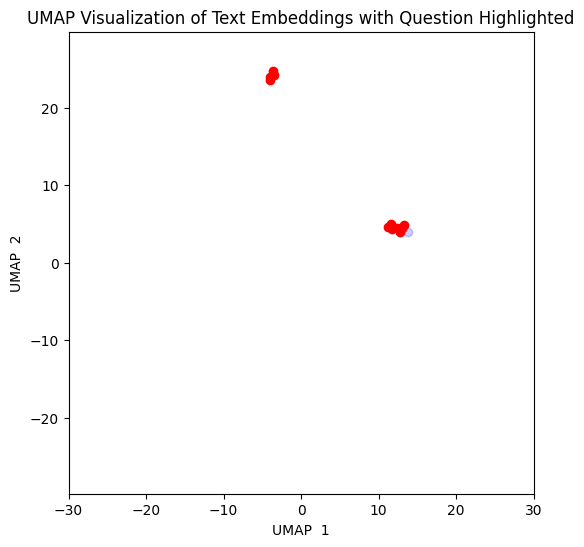

In [72]:
import umap
import numpy as np
import matplotlib.pyplot as plt

# Prepare the embeddings for UMAP
embeddings = np.array([np.array(x) for x in row_embeds])

# Reduce dimensionality with UMAP
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1, n_components=2, random_state=42)
embedding_reduced = reducer.fit_transform(embeddings)
query_reduced = reducer.transform(q_embed)

plt.figure(figsize=(6, 6))
plt.axis('equal')
plt.xlim(global_min, global_max)
plt.ylim(global_min, global_max)
# Plot the reduced embeddings
plt.scatter(query_reduced[:,  0], query_reduced[:,  1], c='blue', alpha=0.2)

# Highlight the question embedding and the  5 closest vectors
plt.scatter(embedding_reduced[:,  0], embedding_reduced[:,  1], c='red', alpha=1)
# plt.scatter(embedding_reduced[df["id"] == df[df["dist"] == df["dist"].min()]["id"].values[0],  0], embedding_reduced[df["id"] == df[df["dist"] == df["dist"].min()]["id"].values[0],  1], c='blue', alpha=1, marker='*')

# Add labels and title
plt.title("UMAP Visualization of Text Embeddings with Question Highlighted")
plt.xlabel("UMAP  1")
plt.ylabel("UMAP  2")
plt.show()

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy

cosine_similarities = cosine_similarity(q_embed, row_embeds)
closest_vectors_indices = numpy.argsort(cosine_similarities[0])[-4:][::-1]
closest_vectors_scores = cosine_similarities[0][closest_vectors_indices]

for i, idx in enumerate(closest_vectors_indices):
    print(f"Score: {closest_vectors_scores[i]}, Row: {rows[idx]}")

Score: 0.5482973456382751, Row: {'project_id': 3, 'title': 'Automated Data Entry', 'description': 'Develop a system that can automatically enter data into a database from various sources.'}
Score: 0.28474557399749756, Row: {'project_id': 1, 'title': 'Employee HelpDesk', 'description': 'Develop software to enhance and enable technicians to provide assistance to employees.'}
Score: 0.2832058370113373, Row: {'project_id': 10, 'title': 'Smart Home Automation System', 'description': 'Create a system that can automate and control various devices in a smart home.'}
Score: 0.25437596440315247, Row: {'project_id': 7, 'title': 'Social Media Analytics Tool', 'description': 'Develop a tool that can analyze and provide insights on social media data.'}


In [69]:
rows_wo_json = [str(str(row["project_id"]) + '; ' + row['title'] + '; ' + row["description"]) for row in rows]
row_embeds_2 = model.encode(rows_wo_json)
rows_wo_json[0]

'1; Employee HelpDesk; Develop software to enhance and enable technicians to provide assistance to employees.'

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


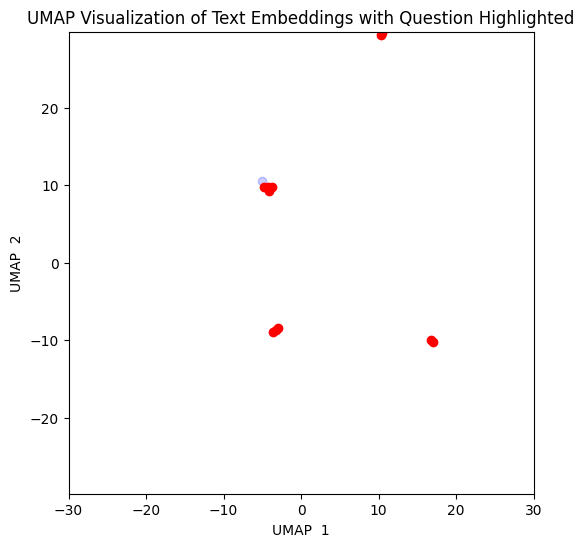

In [73]:
embeddings = np.array([np.array(x) for x in row_embeds_2])

# Reduce dimensionality with UMAP
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1, n_components=2, random_state=42)
embedding_reduced = reducer.fit_transform(embeddings)
query_reduced = reducer.transform(q_embed)
# Plot the reduced embeddings
plt.figure(figsize=(6, 6))
plt.axis('equal')
plt.xlim(global_min, global_max)
plt.ylim(global_min, global_max)
plt.scatter(query_reduced[:,  0], query_reduced[:,  1], c='blue', alpha=0.2)

# Highlight the question embedding and the  5 closest vectors
plt.scatter(embedding_reduced[:,  0], embedding_reduced[:,  1], c='red', alpha=1)

# Add labels and title
plt.title("UMAP Visualization of Text Embeddings with Question Highlighted")
plt.xlabel("UMAP  1")
plt.ylabel("UMAP  2")
plt.show()

In [74]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy

cosine_similarities = cosine_similarity(q_embed, row_embeds_2)
closest_vectors_indices = numpy.argsort(cosine_similarities[0])[-4:][::-1]
closest_vectors_scores = cosine_similarities[0][closest_vectors_indices]

for i, idx in enumerate(closest_vectors_indices):
    print(f"Score: {closest_vectors_scores[i]}, Row: {rows_wo_json[idx]}")

Score: 0.7760639190673828, Row: 3; Automated Data Entry; Develop a system that can automatically enter data into a database from various sources.
Score: 0.43231236934661865, Row: 10; Smart Home Automation System; Create a system that can automate and control various devices in a smart home.
Score: 0.40793299674987793, Row: 4; Inventory Management System; Create a system to track and manage inventory in a warehouse or store.
Score: 0.3983978033065796, Row: 1; Employee HelpDesk; Develop software to enhance and enable technicians to provide assistance to employees.


In [75]:
from scipy.spatial.distance import cdist

distances = cdist(row_embeds, row_embeds, "cosine")
mean_distance = np.mean(distances)
print(f"Average distance between vectors with JSON structure included: {mean_distance}")

distances = cdist(row_embeds_2, row_embeds_2, "cosine")
mean_distance = np.mean(distances)
print(f"Average distance without JSON structure: {mean_distance}")

Average distance between vectors with JSON structure included: 0.31624439762906154
Average distance without JSON structure: 0.596461488547043
